In [1]:
import os
import random
import requests

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torchvision
import pytorch_lightning as pl

from torch.optim import AdamW
from torch.utils.data import DataLoader, Subset, Sampler

from torchvision import models, datasets, transforms
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

from transformers import AutoImageProcessor, AutoModelForImageClassification

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


## Download 2 types of images with unbalanced distribution

In [2]:
# Descargar dataset desbalanceado (clase 0 >> clase 1) con imágenes 224x224
# Usa CIFAR-10 (clase 0 = airplane, clase 1 = automobile)
# Genera estructura:
# dataset/
#   train/
#       0/
#       1/
#   val/
#       0/
#       1/

# ---------------- CONFIG ----------------
root_dir = "dataset"
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

num_class0_trainvaltest = 5000  # total a muestrear de clase 0 en train+val+test
num_class1_trainvaltest = 500   # total a muestrear de clase 1 en train+val+test

img_size = 224
seed = 42
# ----------------------------------------

assert abs((train_ratio + val_ratio + test_ratio) - 1.0) < 1e-9

random.seed(seed)
np.random.seed(seed)

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
])

cifar = datasets.CIFAR10(root="data", train=True, download=True)
targets = cifar.targets

idx0 = [i for i, t in enumerate(targets) if t == 0]  # airplane
idx1 = [i for i, t in enumerate(targets) if t == 1]  # automobile

random.shuffle(idx0)
random.shuffle(idx1)

idx0 = idx0[:num_class0_trainvaltest]
idx1 = idx1[:num_class1_trainvaltest]

all_indices = idx0 + idx1
random.shuffle(all_indices)

n = len(all_indices)
n_train = int(n * train_ratio)
n_val = int(n * val_ratio)
n_test = n - n_train - n_val

train_idx = all_indices[:n_train]
val_idx = all_indices[n_train:n_train + n_val]
test_idx = all_indices[n_train + n_val:]

def save_subset(indices, split_name):
    for idx in tqdm(indices, desc=f"Saving {split_name}"):
        img, label = cifar[idx]
        img = transform(img)
        class_label = 0 if label == 0 else 1
        save_path = os.path.join(root_dir, split_name, str(class_label))
        os.makedirs(save_path, exist_ok=True)
        img.save(os.path.join(save_path, f"{idx}.png"))

save_subset(train_idx, "train")
save_subset(val_idx, "val")
save_subset(test_idx, "test")

print("Dataset creado correctamente (train/val/test).")
print(f"Total: {n} | train: {len(train_idx)} | val: {len(val_idx)} | test: {len(test_idx)}")

Saving test: 100%|████████████████████████████| 550/550 [00:06<00:00, 88.94it/s]

Dataset creado correctamente (train/val/test).
Total: 5500 | train: 4400 | val: 550 | test: 550


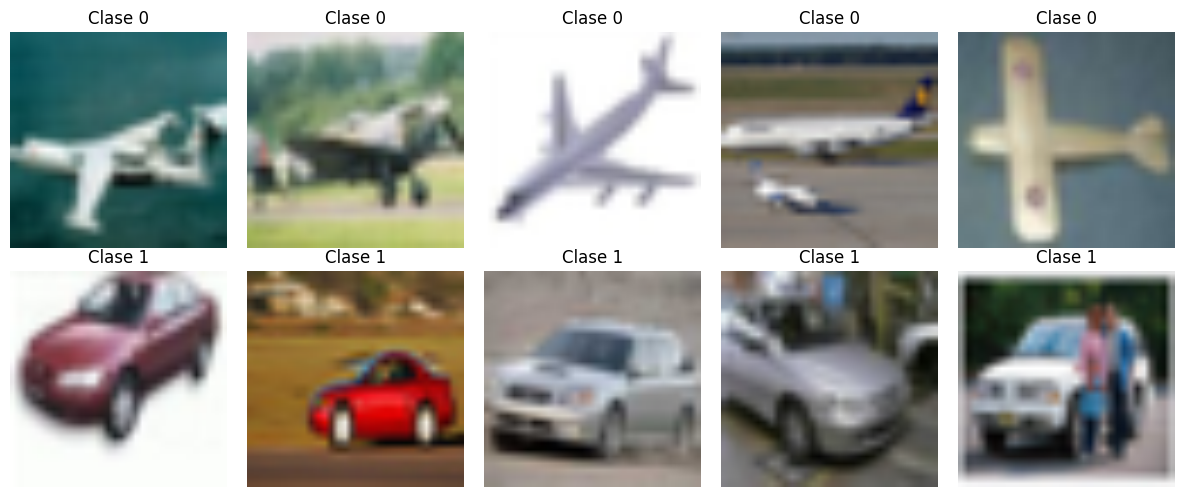

In [3]:


train_dir = "dataset/train"

# 5 imágenes por clase
images_class0 = random.sample(os.listdir(os.path.join(train_dir, "0")), 5)
images_class1 = random.sample(os.listdir(os.path.join(train_dir, "1")), 5)

fig, axes = plt.subplots(2, 5, figsize=(12, 5))

# Fila 0 -> clase 0
for col in range(5):
    img_path = os.path.join(train_dir, "0", images_class0[col])
    img = Image.open(img_path)
    axes[0, col].imshow(img)
    axes[0, col].set_title("Clase 0")
    axes[0, col].axis("off")

# Fila 1 -> clase 1
for col in range(5):
    img_path = os.path.join(train_dir, "1", images_class1[col])
    img = Image.open(img_path)
    axes[1, col].imshow(img)
    axes[1, col].set_title("Clase 1")
    axes[1, col].axis("off")

plt.tight_layout()
plt.show()

## Load a transformer trained in ImageNet-1k

In [4]:

url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/hub/parrots.png"
image = Image.open(requests.get(url, stream=True).raw)


model_name = "facebook/deit-base-patch16-224"

processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModelForImageClassification.from_pretrained(model_name)


# -------- PRINT IMAGE --------
print("type:", type(image))

if isinstance(image, np.ndarray):
    print("shape:", image.shape)
    print("ndim:", image.ndim)
    if image.ndim == 2:
        image = np.stack([image]*3, axis=-1)
    image = Image.fromarray(image)

print("PIL mode before:", image.mode)

image = image.convert("RGB")

print("PIL mode after:", image.mode)
print("size:", image.size)

# -------- INFERENCIA --------
with torch.no_grad():
    inputs = processor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    logits = outputs.logits

predicted_class_id = logits.argmax(-1).item()

print("Clase predicha:", model.config.id2label[predicted_class_id])

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


type: <class 'PIL.PngImagePlugin.PngImageFile'>
PIL mode before: L
PIL mode after: RGB
size: (768, 512)
Clase predicha: macaw


# Descongelar LayerNorm + últimos bloques (más estable)

In [5]:
# ============================================
# Descongelar classifier + últimos 2 bloques (ViT HF)
# ============================================


# 1️⃣ Cambiar a 1 logit
model.config.num_labels = 1
in_features = model.classifier.in_features
model.classifier = nn.Linear(in_features, 1)

# 2️⃣ Congelar TODO el modelo
for param in model.parameters():
    param.requires_grad = False

# 3️⃣ Descongelar últimos 2 bloques Transformer
# (compatible con ViT y DeiT en HuggingFace)

for block in model.vit.encoder.layer[-2:]:
    for param in block.parameters():
        param.requires_grad = True

# 4️⃣ Descongelar LayerNorm final
for param in model.vit.layernorm.parameters():
    param.requires_grad = True

# 5️⃣ Descongelar classifier
for param in model.classifier.parameters():
    param.requires_grad = True

# ============================================
# Verificación
# ============================================

trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())

print(f"Trainable params: {trainable:,}")
print(f"Total params: {total:,}")
print(f"Trainable %: {100 * trainable / total:.4f}%")

Trainable params: 14,178,049
Total params: 85,799,425
Trainable %: 16.5246%


In [6]:
# Verificar qué se está entrenando
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())

print(f"Trainable params: {trainable:,}")
print(f"Total params: {total:,}")
print(f"% trainable: {100*trainable/total:.2f}%")

Trainable params: 14,178,049
Total params: 85,799,425
% trainable: 16.52%


## Augmentation and dataloader

In [7]:
# ============================================
# BalancedBatchSampler
# Genera batches SIEMPRE balanceados 50/50
# ============================================

class BalancedBatchSampler(Sampler):
    def __init__(self, dataset, batch_size):
        self.dataset = dataset
        self.batch_size = batch_size
        self.targets = torch.tensor(dataset.targets)

        assert batch_size % 2 == 0, "batch_size debe ser par"

        self.class0_idx = torch.where(self.targets == 0)[0].tolist()
        self.class1_idx = torch.where(self.targets == 1)[0].tolist()

        self.min_class_size = min(len(self.class0_idx), len(self.class1_idx))
        self.num_batches = self.min_class_size // (batch_size // 2)

    def __iter__(self):
        random.shuffle(self.class0_idx)
        random.shuffle(self.class1_idx)

        for i in range(self.num_batches):
            batch0 = self.class0_idx[i*(self.batch_size//2):(i+1)*(self.batch_size//2)]
            batch1 = self.class1_idx[i*(self.batch_size//2):(i+1)*(self.batch_size//2)]

            batch = batch0 + batch1
            random.shuffle(batch)
            yield batch

    def __len__(self):
        return self.num_batches


# ============================================
# Transforms
# ============================================

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomChoice([
        transforms.RandomRotation((0, 0)),
        transforms.RandomRotation((90, 90)),
        transforms.RandomRotation((180, 180)),
        transforms.RandomRotation((270, 270)),
    ]),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])

eval_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])

# ============================================
# Datasets
# ============================================

train_dataset = datasets.ImageFolder(
    root="dataset/train",
    transform=train_transforms
)

val_dataset = datasets.ImageFolder(
    root="dataset/val",
    transform=eval_transforms
)

test_dataset = datasets.ImageFolder(
    root="dataset/test",
    transform=eval_transforms
)

# ============================================
# DataLoaders con batches balanceados
# ============================================

batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_sampler=BalancedBatchSampler(train_dataset, batch_size),
    num_workers=4
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4
)

print("Clases:", train_dataset.classes)
print("Train size:", len(train_dataset))
print("Val size:", len(val_dataset))
print("Test size:", len(test_dataset))

Clases: ['0', '1']
Train size: 4400
Val size: 550
Test size: 550


Seed set to 42


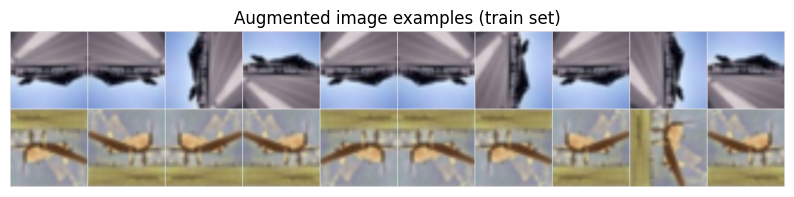

In [8]:


pl.seed_everything(42)

NUM_IMAGES = 2  # número de imágenes base

# Dataset con transforms de TRAIN (augmentations activos)
aug_dataset = datasets.ImageFolder(
    root="dataset/train",
    transform=train_transforms  # <-- usa el transform con augmentations
)

# Tomar N imágenes y generar múltiples vistas (ej. 6 augmentations por imagen)
imgs = torch.stack(
    [aug_dataset[idx][0] for idx in range(NUM_IMAGES) for _ in range(10)],
    dim=0
)

img_grid = torchvision.utils.make_grid(
    imgs,
    nrow=10,
    normalize=True,
    pad_value=0.9
)

img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(10, 5))
plt.title("Augmented image examples (train set)")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

In [9]:
# =========================================================
# BCE + Weight Decay + F1 robusto (sin errores de acumulación)
# =========================================================

import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.optim import AdamW
from torchmetrics.classification import BinaryF1Score


class LitViT(pl.LightningModule):
    def __init__(self, model, lr=3e-5, weight_decay=0.01):
        super().__init__()
        self.model = model
        self.save_hyperparameters(ignore=["model"])

        self.criterion = nn.BCEWithLogitsLoss()

        # acumulación correcta por epoch
        self.train_f1 = BinaryF1Score()
        self.val_f1 = BinaryF1Score()

    def forward(self, x):
        return self.model(pixel_values=x).logits.squeeze(1)

    def training_step(self, batch, batch_idx):
        images, labels = batch

        logits = self(images)
        loss = self.criterion(logits, labels.float())

        probs = torch.sigmoid(logits)
        self.train_f1.update(probs, labels)

        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)

        return loss

    def on_train_epoch_end(self):
        f1 = self.train_f1.compute()
        self.log("train_f1", f1, prog_bar=True)
        self.train_f1.reset()

    def validation_step(self, batch, batch_idx):
        images, labels = batch

        logits = self(images)
        loss = self.criterion(logits, labels.float())

        probs = torch.sigmoid(logits)
        self.val_f1.update(probs, labels)

        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)

    def on_validation_epoch_end(self):
        f1 = self.val_f1.compute()
        self.log("val_f1", f1, prog_bar=True)
        self.val_f1.reset()

    def configure_optimizers(self):
        return AdamW(
            filter(lambda p: p.requires_grad, self.parameters()),
            lr=self.hparams.lr,
            weight_decay=self.hparams.weight_decay  # ✅ agregado
        )



In [10]:
# =========================================================
# Entrenamiento
# =========================================================

lit_model = LitViT(model)

trainer = pl.Trainer(
    max_epochs=10,
    accelerator="auto",
    devices="auto",
    log_every_n_steps=10,
    logger=pl.loggers.TensorBoardLogger("tb_logs")
)

trainer.fit(lit_model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params | Mode  | FLOPs


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/nicolas/miniconda3/envs/transformer/lib/python3.13/site-packages/pytorch_lightning/loops/fit_loop.py:534: Found 213 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If this is intentional, you can ignore this warning.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


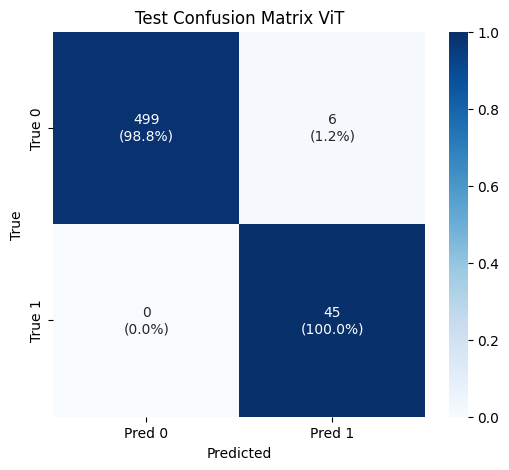

In [11]:
lit_model.eval()
all_preds = []
all_targets = []

with torch.inference_mode():
    for images, labels in test_loader:
        images = images.to(lit_model.device)
        labels = labels.to(lit_model.device)

        logits = lit_model(images)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).int()

        all_preds.append(preds.cpu())
        all_targets.append(labels.cpu())

all_preds = torch.cat(all_preds).numpy()
all_targets = torch.cat(all_targets).numpy()

cm = confusion_matrix(all_targets, all_preds)

# Normalización por fila
cm_percent = cm.astype(np.float32) / cm.sum(axis=1, keepdims=True)

# Crear etiquetas combinadas
labels = np.empty_like(cm).astype(str)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        percent = cm_percent[i, j] * 100
        labels[i, j] = f"{count}\n({percent:.1f}%)"

plt.figure(figsize=(6,5))
sns.heatmap(
    cm_percent,
    annot=labels,
    fmt="",
    cmap="Blues",
    cbar=True,
    xticklabels=["Pred 0", "Pred 1"],
    yticklabels=["True 0", "True 1"]
)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Test Confusion Matrix ViT")
plt.show()

In [12]:
# =========================================================
# ResNet18
# Descongelar último bloque (layer4) + FC
# Similar a descongelar últimos bloques en ViT
# =========================================================

import torch
import torch.nn as nn
import pytorch_lightning as pl
import torchvision.models as models
from torch.optim import AdamW
from torchmetrics.classification import BinaryF1Score


# =========================================================
# 1️⃣ Modelo base
# =========================================================

resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Congelar todo
for param in resnet.parameters():
    param.requires_grad = False

# Cambiar FC → 1 logit
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, 1)

# Descongelar último bloque (layer4)
for param in resnet.layer4.parameters():
    param.requires_grad = True

# Descongelar FC
for param in resnet.fc.parameters():
    param.requires_grad = True


# =========================================================
# 2️⃣ Lightning Module
# =========================================================

class LitResNet(pl.LightningModule):
    def __init__(self, model, lr=1e-4, weight_decay=0.01):
        super().__init__()
        self.model = model
        self.save_hyperparameters(ignore=["model"])

        self.criterion = nn.BCEWithLogitsLoss()

        self.train_f1 = BinaryF1Score()
        self.val_f1 = BinaryF1Score()

    def forward(self, x):
        return self.model(x).squeeze(1)

    def training_step(self, batch, batch_idx):
        images, labels = batch

        logits = self(images)
        loss = self.criterion(logits, labels.float())

        probs = torch.sigmoid(logits)
        self.train_f1.update(probs, labels)

        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def on_train_epoch_end(self):
        f1 = self.train_f1.compute()
        self.log("train_f1", f1, prog_bar=True)
        self.train_f1.reset()

    def validation_step(self, batch, batch_idx):
        images, labels = batch

        logits = self(images)
        loss = self.criterion(logits, labels.float())

        probs = torch.sigmoid(logits)
        self.val_f1.update(probs, labels)

        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)

    def on_validation_epoch_end(self):
        f1 = self.val_f1.compute()
        self.log("val_f1", f1, prog_bar=True)
        self.val_f1.reset()

    def configure_optimizers(self):
        # entrenar solo layer4 + fc
        params = list(self.model.layer4.parameters()) + list(self.model.fc.parameters())

        return AdamW(
            params,
            lr=self.hparams.lr,
            weight_decay=self.hparams.weight_decay
        )


# =========================================================
# 3️⃣ Entrenamiento
# =========================================================

lit_model = LitResNet(resnet)

trainer = pl.Trainer(
    max_epochs=10,
    accelerator="auto",
    devices="auto",
    log_every_n_steps=10
)

trainer.fit(lit_model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode  | FLOPs
----------------------------------------------------------------
0 | model     | ResNet            | 11.2 M | train | 0    
1 | criterion | BCEWithLogitsLoss | 0      | train | 0    
2 | train_f1  | BinaryF1Score     | 0      | train | 0    
3 | val_f1    | BinaryF1Score     | 0      | train | 0    
----------------------------------------------------------------
8.4 M     Trainab

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


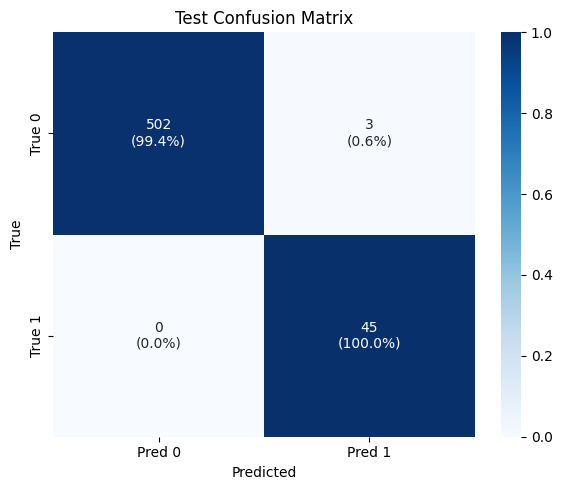

In [13]:
# =========================================================
# Confusion Matrix robusta (funciona para ResNet BCE 1-logit)
# =========================================================


lit_model.eval()

device = lit_model.device
all_preds = []
all_targets = []

with torch.inference_mode():
    for images, labels in test_loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        logits = lit_model(images)              # [B]
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).int()

        all_preds.append(preds.cpu())
        all_targets.append(labels.cpu())

# Concatenar correctamente
all_preds = torch.cat(all_preds).numpy()
all_targets = torch.cat(all_targets).numpy()

# Matriz absoluta
cm = confusion_matrix(all_targets, all_preds)

# Evitar división por cero si una clase no aparece
row_sums = cm.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1

cm_percent = cm.astype(np.float32) / row_sums

# Etiquetas combinadas
labels = np.empty_like(cm).astype(str)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        percent = cm_percent[i, j] * 100
        labels[i, j] = f"{count}\n({percent:.1f}%)"

plt.figure(figsize=(6,5))
sns.heatmap(
    cm_percent,
    annot=labels,
    fmt="",
    cmap="Blues",
    cbar=True,
    xticklabels=["Pred 0", "Pred 1"],
    yticklabels=["True 0", "True 1"]
)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Test Confusion Matrix")
plt.tight_layout()
plt.show()